In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


For telco companies it is crucial to attract new customers and at the same time
to avoid churning.

It costs the company a lot when the customers churn.

The key challenge is to predict if an individual customer will churn or not.

The extra challenge is to identify the key components of churning.

1.1 Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import tkinter
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score
from collections import Counter

import os
print(os.listdir("/content/drive/MyDrive/archive (1)"))

['WA_Fn-UseC_-Telco-Customer-Churn.csv']


1.2 Importing Data

In [3]:
raw_df = pd.read_csv('/content/drive/MyDrive/archive (1)/WA_Fn-UseC_-Telco-Customer-Churn.csv')

2 Exploring Data Set

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Observations from the dataset

There are total of 21 columns: 3 numerical, 16 categorical, 1 id and 1 target column

'Total Charges' provides a numerical values, but the numbers are stored as on object

Some categorical features are stored as a string

There are 7043 rows in entire data set

Churn is the target variable

# 2. Quick overview

In [5]:
raw_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


The data set includes information about:

Customers who left within the last month – the column is called Churn

Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies

Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges

Demographic info about customers – gender, age range, and if they have partners and dependents

# 3. Data Preprocessing

In [6]:
df = raw_df.drop('customerID', axis=1)

3.1 Dealing with missing values

In [7]:
df.isna().sum()       # no missing values

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

3.2 Dealin with error: could not convert string to float: '

In [8]:
# df['TotalCharges'] = df['TotalCharges'].astype(float)
# The string to be converted must not contain any characters or symbols.error occurs due to the incorrect initialization of value to a string variable.
# probably there are empty strings in 'TotalCharges' colums, but as they were defined as string, they didn't appear as Null Values.

step1 = [len(i.split()) for i in df['TotalCharges']] # splitting individual elements of 'Total_Charges'
step2 = [i for i in range(len(step1)) if step1[i] != 1] # storing the index values of 'Total_Charges' where length is not equal to 1.
print('Number of entries with empty string: ', len(step2))


Number of entries with empty string:  11


In [9]:
# it's simpler (and probably better) to just drop the coresponding rows from a dataset as the numbers of empty string is very low (11).
df = df.drop(step2, axis = 0).reset_index(drop=True) # Dropping rows with no values in 'Total_charges'

df['TotalCharges'] = df['TotalCharges'].astype(float) # Finally we can convert string to float in 'Total_charges' column

3.3 Dealing with duplicated values

In [10]:
print('Number of duplicated values in training dataset: ', df.duplicated().sum())

Number of duplicated values in training dataset:  22


In [11]:
df.drop_duplicates(inplace=True)    # deleting duplicate values

3.4 Creating numerical and categorical lists

In [12]:
# distinction is based on the number of different values in the column

columns = list(df.columns)

categoric_columns = []
numeric_columns = []

for i in columns:
    if len(df[i].unique()) > 6:
        numeric_columns.append(i)
    else:
        categoric_columns.append(i)

categoric_columns = categoric_columns[:-1] # Excluding 'Churn'




numeric_columns

['tenure', 'MonthlyCharges', 'TotalCharges']

3.5 Label Encoding

In [13]:
# Label Encoding refers to converting the labels into a numeric form.
# This is only for EDA reasons. Later will use OneHotEncoder to prepare for model building.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df1 = df.copy()

df1[categoric_columns] = df1[categoric_columns].apply(le.fit_transform)
df1[['Churn']] = df1[['Churn']].apply(le.fit_transform)

3.6 Train dataset - Basic statistics

In [14]:
df1[numeric_columns].describe()

,tenure,MonthlyCharges,TotalCharges
count,7010.000000,7010.000000,7010.000000
mean,32.520399,64.888666,2290.353388
std,24.520441,30.064769,2266.820832
min,1.000000,18.250000,18.800000
25%,9.000000,35.750000,408.312500
50%,29.000000,70.400000,1403.875000
75%,56.000000,89.900000,3807.837500
max,72.000000,118.750000,8684.800000


In [15]:
#Defining colors for the plots
palette = ['#008080','#FF6347', '#E50000', '#D2691E']
palette2 = ['#FF6347', '#008080', '#E50000', '#D2691E']

# 4. Data Imbalance Check

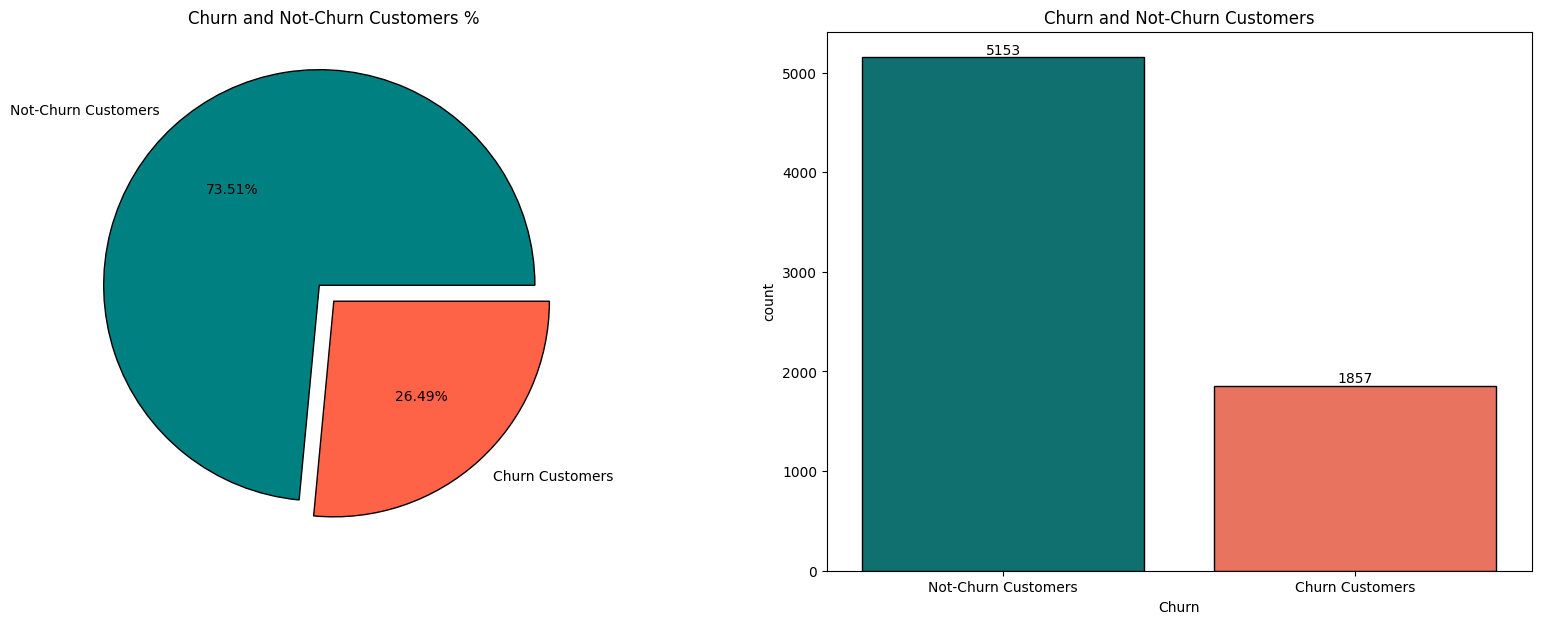

In [16]:
l1 = list(df1['Churn'].value_counts())
pie_values = [l1[0] / sum(l1) * 100, l1[1] / sum(l1) * 100]

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,7))

plt.subplot(1,2,1)
plt.pie(pie_values,labels = ['Not-Churn Customers','Churn Customers'],
        autopct = '%1.2f%%',
        explode = (0.1,0),
        colors = palette,
        wedgeprops = {'edgecolor': 'black','linewidth': 1, 'antialiased' : True})
plt.title('Churn and Not-Churn Customers %');

plt.subplot(1,2,2)
ax = sns.countplot(data = df1,
                   x='Churn',
                   palette = palette,
                   edgecolor = 'black')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['Not-Churn Customers','Churn Customers'])

plt.title('Churn and Not-Churn Customers')
plt.show()

4.1 Imbalanced data requires different approach

Dataset is imbalanced with almost 1:4 ratio. It's not an extreme value, but it's still significant.

This means that a blind guess (bet on "Not-Churn") would give us accuracy of 73,51%.

Use stratified splitting during train-test split.
Be extra careful when dealing with outliers (we can delete meaningull information).
Consider undersampling or oversampling techniques.

4.2 Choosing the most suitable metrics

We can assume that additional actions (to prevent churning) will help if applied to any Customer (churning or not).

We can also expect that the additional care (or other activities) will cost us more effort.

And that’s why…

We want to avoid the situation when we identify churn Customer as not-churn, because in such case we lose the opportunity to prevent churn.

When a not-churn Customer is identified as churning an extra effort will make no negative effect for the customer, but it will cost us extra effort. We can probably afford this scenario to some extent if it helps with churning customer identification.

we want to avoid false negatives as much as possible. A false negative case means that a churn-positive customer is assessed to not-churn, which is detrimental. False positives (a not-churn identified as churn) are not as important as preventing a churning. It will make no negative effect for the customer, but it will cost us extra effort.

The most suitable metrics are:

Recall: the ability of a model to find all the relevant cases within a data set.

ROC-AUC: ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes.

# 5. EDA

5.1 Checking distributions

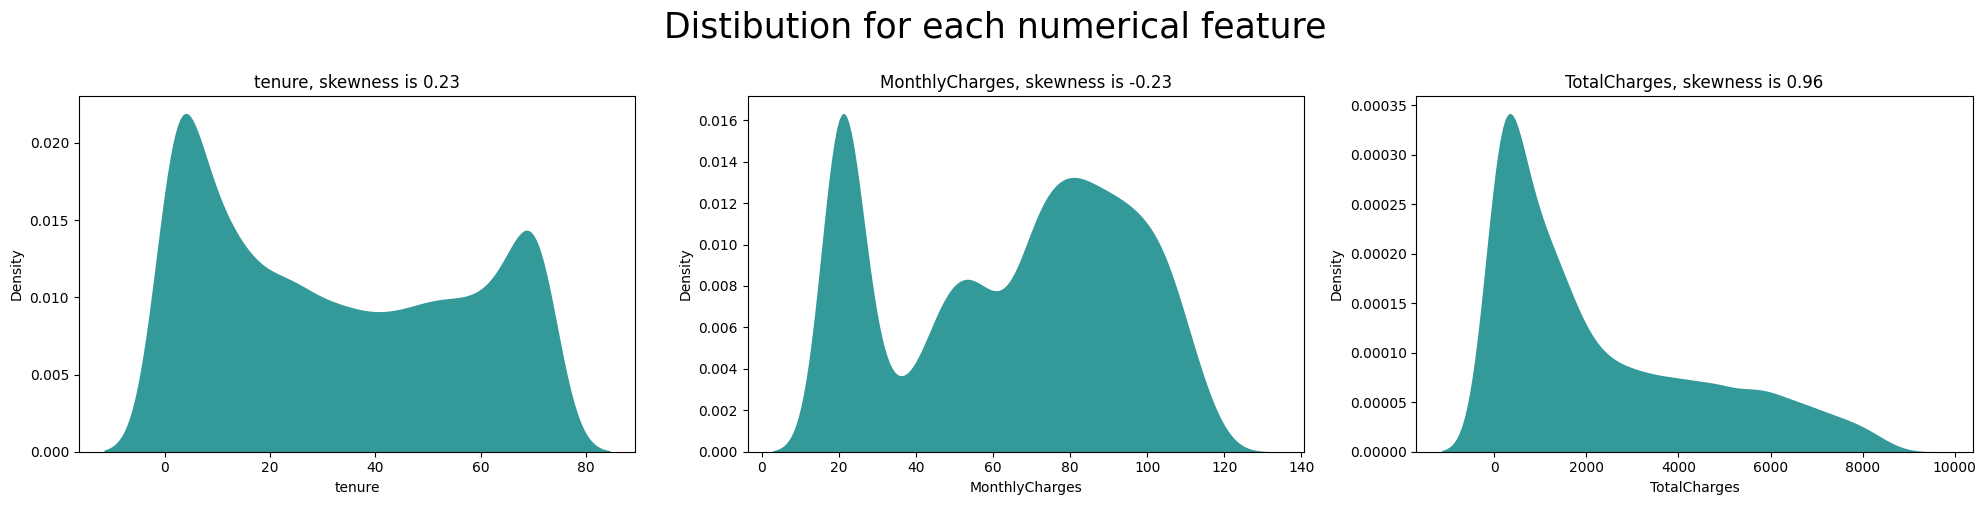

In [17]:
# Checking for distributions
def dist_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols,figsize=(20,5))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.kdeplot(dataset[data], ax=axs[i], fill=True, alpha=0.8, linewidth=0, color='#008080')
        axs[i].set_title(data + ', skewness is '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

dist_custom(dataset=df1, columns_list=numeric_columns, rows=1, cols=3, suptitle='Distibution for each numerical feature')
plt.tight_layout()

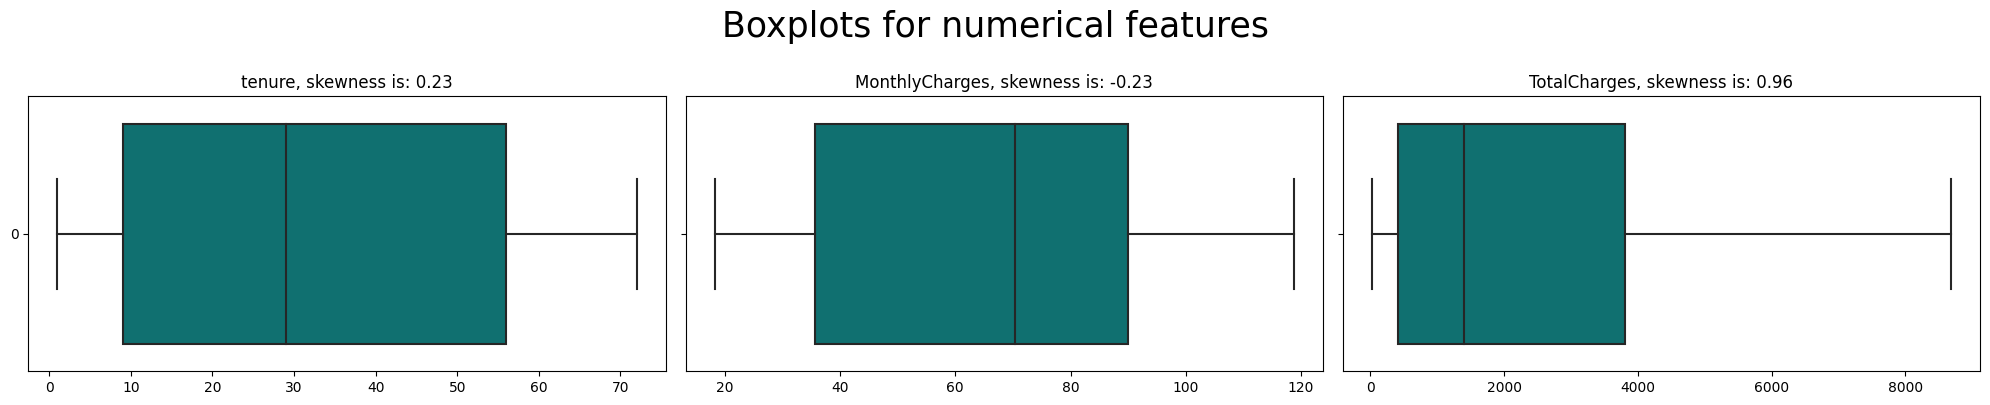

In [18]:
# checking boxplots
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(20,4))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i], palette = palette)
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))

boxplots_custom(dataset=df1, columns_list=numeric_columns, rows=1, cols=3, suptitle='Boxplots for numerical features')
plt.tight_layout()




# variables are not normally distributed;
# tenure and MonthlyCharges created kind of a bimodal distribution;
# TotalCharges is rightly skewed.

5.2 Checking for outliers - Inter Quartile Range (IQR)

Find the first quartile, Q1.

Find the third quartile, Q3.

Calculate the IQR. IQR = Q3-Q1.

Define the normal data range with lower limit as Q1–1.5 IQR and upper limit as Q3+1.5 IQR.



In [19]:
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations
    containing more than n outliers according to the IQR method.
    """
    outlier_list = []

    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers
        outlier_list.extend(outlier_list_column)

    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )

    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]

    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])

    return multiple_outliers

In [20]:
# Detecting and dropping outliers
Outliers_IQR = IQR_method(df,1,numeric_columns)
df_out = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 0


In [21]:
# Checking results
print ('The amount of frauds in df before dropping outliers: ', len(df[df['Churn'] == 1]))
print ('The amount of frauds in df after dropping outliers: ', len(df_out[df_out['Churn'] == 1]))

# in this senario we dont have problem with outliers

The amount of frauds in df before dropping outliers:  0
The amount of frauds in df after dropping outliers:  0


5.3 Numerical Features vs Target Variable (Churn)

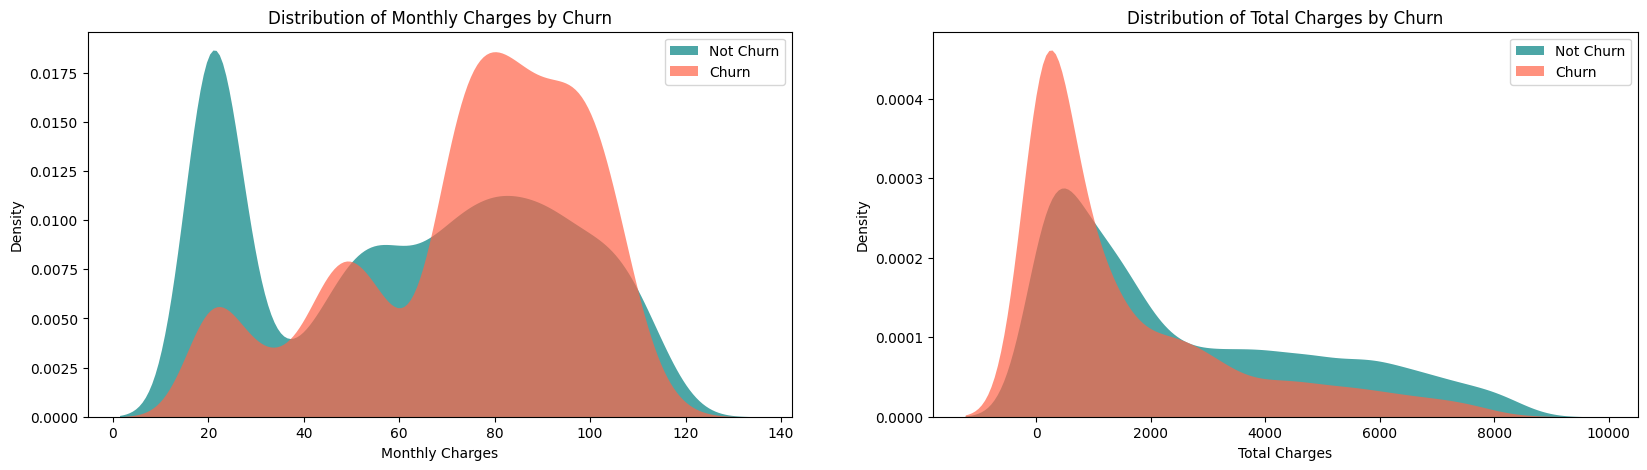

In [22]:
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,5))

plt.subplot(1,2,1)
ax = sns.kdeplot(df1.MonthlyCharges[(df1["Churn"] == 0)], color='#008080', fill= True, alpha=.7, linewidth=0)
ax = sns.kdeplot(df1.MonthlyCharges[(df1["Churn"] == 1)], color='#FF6347', fill= True, alpha=.7, linewidth=0)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Monthly Charges')
ax.set_title('Distribution of Monthly Charges by Churn')

plt.subplot(1,2,2)
ax = sns.kdeplot(df1.TotalCharges[(df1["Churn"] == 0)], color='#008080', fill= True, alpha=.7, linewidth=0)
ax = sns.kdeplot(df1.TotalCharges[(df1["Churn"] == 1)], color='#FF6347', fill= True, alpha=.7, linewidth=0)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of Total Charges by Churn')
plt.show()

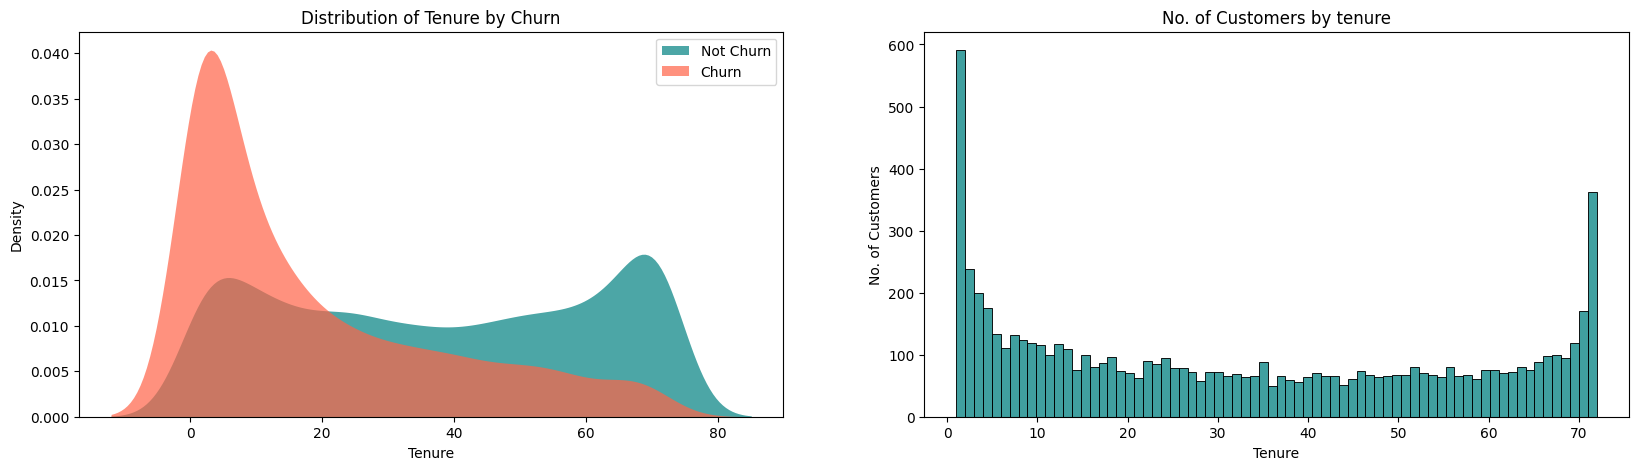

In [23]:
#plt.figure(figsize=(7,3))

fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,5))

plt.subplot(1,2,1)
ax = sns.kdeplot(df1.tenure[(df1["Churn"] == 0)], color='#008080', fill= True, alpha=.7, linewidth=0)
ax = sns.kdeplot(df1.tenure[(df1["Churn"] == 1)], color='#FF6347', fill= True, alpha=.7, linewidth=0)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Tenure')
ax.set_title('Distribution of Tenure by Churn')

plt.subplot(1,2,2)
ax = sns.histplot(df1["tenure"], bins=72, kde=False, color='#008080')
ax.set(title = "No. of Customers by tenure")
ax.set_ylabel('No. of Customers')
ax.set_xlabel('Tenure')

plt.show()



# The longer the customer has been with the provider the more likely he will not churn.

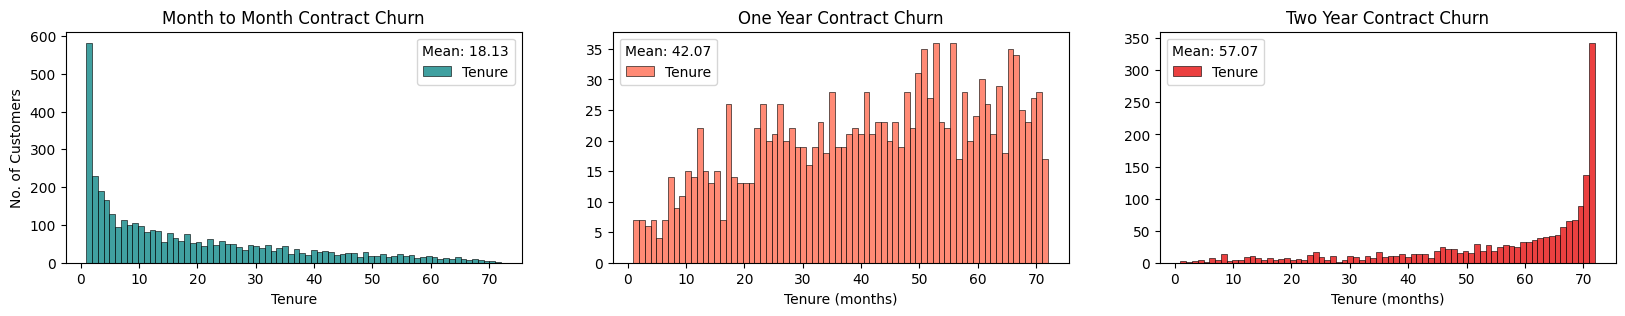

In [24]:
two_year_mean = round(df1[df1['Contract']==2]['tenure'].mean(),2)
month_mean = round(df1[df1['Contract']==0]['tenure'].mean(),2)
year_mean = round(df1[df1['Contract']==1]['tenure'].mean(),2)

fig = plt.subplots(nrows=1, ncols=3, figsize = (20,3))

plt.subplot(1,3,1)
ax = sns.histplot(df1[df1['Contract']==0]['tenure'], bins=72, color = '#008080')
ax.legend(['Tenure'],loc='upper right', title=(f'Mean: {month_mean}'))
ax.set_ylabel('No. of Customers')
ax.set_xlabel('Tenure')
ax.set_title('Month to Month Contract Churn')

plt.subplot(1,3,2)
ax = sns.histplot(df1[df1['Contract']==1]['tenure'], bins=72, color = '#FF6347')
ax.legend(['Tenure'],loc='upper left', title=(f'Mean: {year_mean}'))
ax.set_ylabel('')
ax.set_xlabel('Tenure (months)')
ax.set_title('One Year Contract Churn')

plt.subplot(1,3,3)
ax = sns.histplot(df1[df1['Contract']==2]['tenure'], bins=72, color = '#E50000')
ax.legend(['Tenure'],loc='upper left', title=(f'Mean: {two_year_mean}'))
ax.set_ylabel('')
ax.set_xlabel('Tenure (months)')
ax.set_title('Two Year Contract Churn')

plt.show()


# a lot of Customers churned after just a month
# a lot of Customers are with the provider for 72 weeks
# the longer the contract, the longer customer stays with the provider (higher mean score)

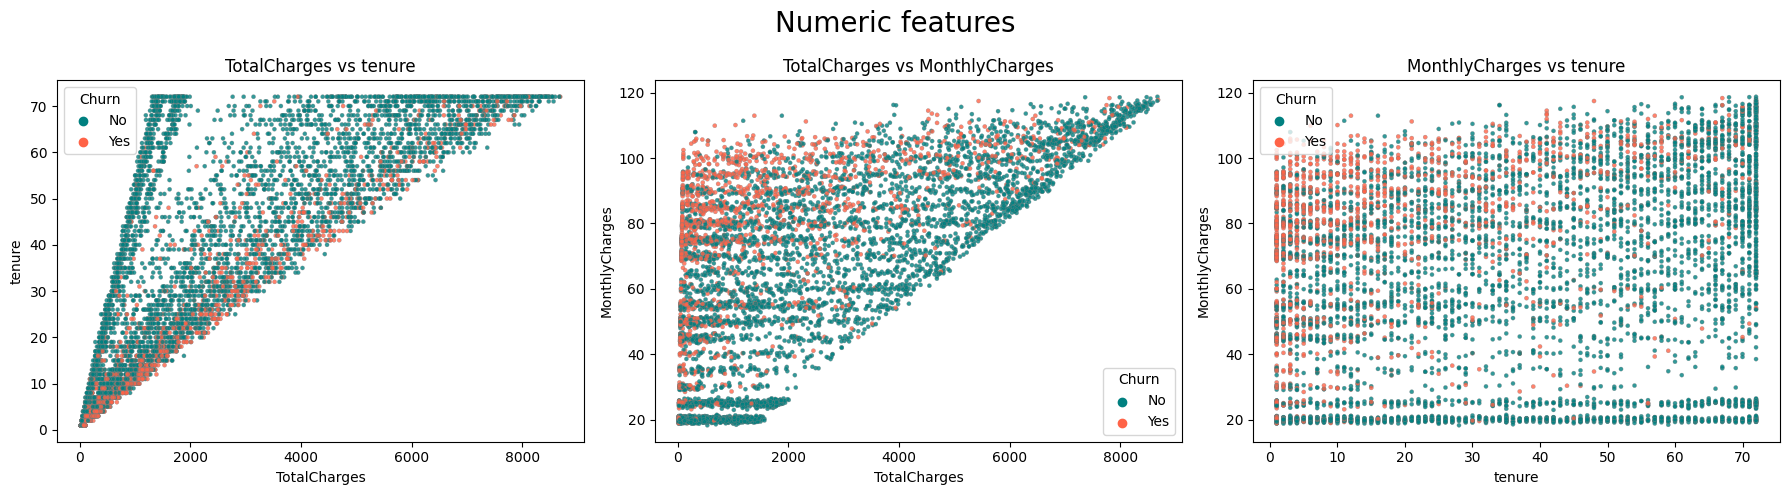

In [25]:
palette2 = ['#008080','#FF6347']

fig = plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
ax1 = sns.scatterplot(x = df['TotalCharges'], y = df['tenure'], hue = "Churn",
                    data = df, palette = palette2, edgecolor='grey', alpha = 0.8, s=9)
plt.title('TotalCharges vs tenure')

plt.subplot(1,3,2)
ax2 = sns.scatterplot(x = df['TotalCharges'], y = df['MonthlyCharges'], hue = "Churn",
                    data = df, palette =palette2, edgecolor='grey', alpha = 0.8, s=9)
plt.title('TotalCharges vs MonthlyCharges')

plt.subplot(1,3,3)
ax2 = sns.scatterplot(x = df['tenure'], y = df['MonthlyCharges'], hue = "Churn",
                    data = df, palette =palette2, edgecolor='grey', alpha = 0.8, s=9)
plt.title('MonthlyCharges vs tenure')

fig.suptitle('Numeric features', fontsize = 20)
plt.tight_layout()
plt.show()

5.4 Summary

a lot of customers churned after just a month

a lot of customers are with the provider for 72 weeks

the longer the contract, the longer customer stays with the provider (higher mean score)

customers with higher Monthly Charges are more likely to churn

the longer the customer has been with the provider the more likely he will not churn.

5.5 Categorical Features vs Target Variable (Churn)

5.5.1 Customer information

Gender, SeniorCitizen, Partner, Dependents

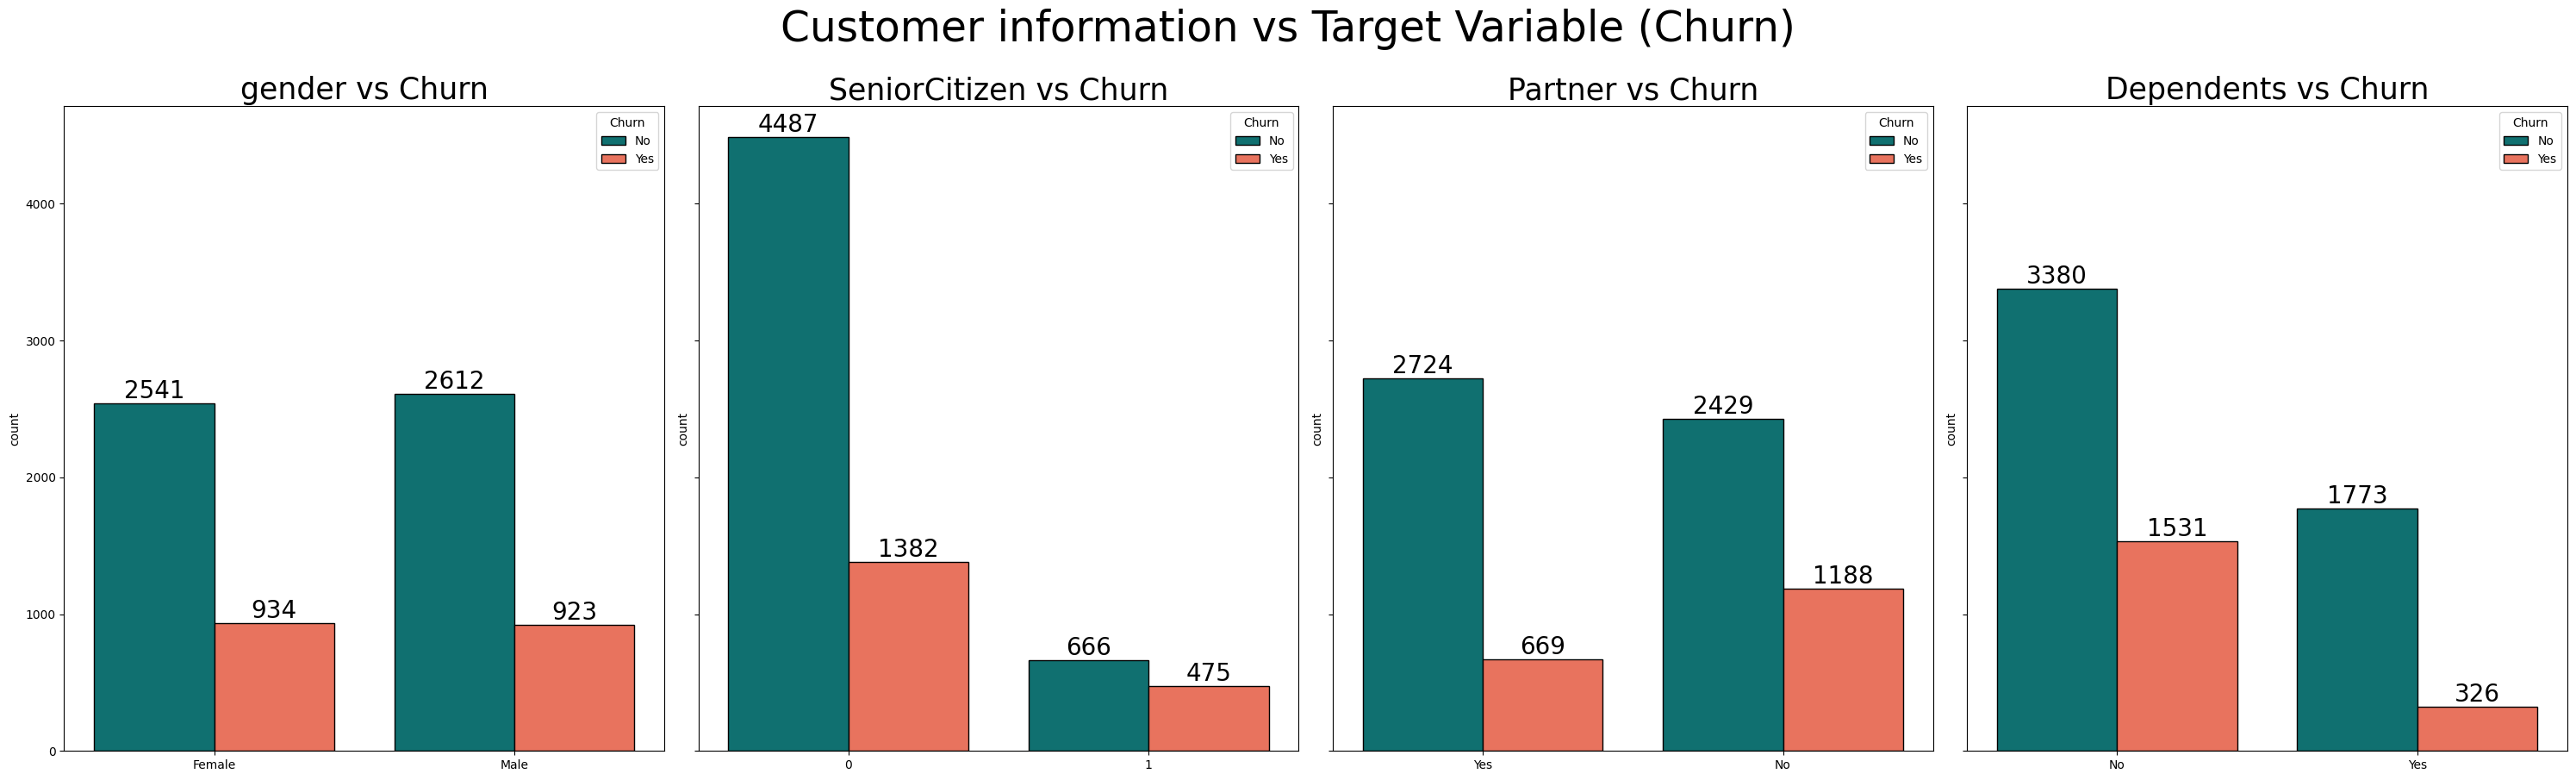

In [26]:
list1 = ['gender','SeniorCitizen','Partner','Dependents']
hue = "Churn"
figsize = (30,9)

# defining function for countplots
def countplots_custom(dataset, columns_list, rows, cols, figsize, suptitle, hue, palette):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=figsize)
    fig.suptitle(suptitle,y=1, size=35)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        ax=sns.countplot(data=dataset, ax=axs[i], x=columns_list[i], hue = hue, palette = palette, edgecolor = 'black')
        axs[i].set_title(data + f' vs {hue}', size=25)
        for i in ax.containers:
            ax.bar_label(i,size=20)
            ax.set_xlabel('')

countplots_custom(dataset=df, columns_list=list1, rows=1, cols=4, figsize=figsize, hue = hue, palette = palette, suptitle='Customer information vs Target Variable (Churn)')
plt.tight_layout()

In [27]:
gender = df1[df1['Churn'] == 1]['gender'].value_counts()
pie_values1 = [gender[0] / sum(gender) * 100, gender[1] / sum(gender) * 100]

senior = df1[df1['Churn'] == 1]['SeniorCitizen'].value_counts()
pie_values2 = [senior[0] / sum(senior) * 100, senior[1] / sum(senior) * 100]

partner = df1[df1['Churn'] == 1]['Partner'].value_counts()
pie_values3 = [partner[0] / sum(partner) * 100, partner[1] / sum(partner) * 100]

dependents = df1[df1['Churn'] == 1]['Dependents'].value_counts()
pie_values4 = [dependents[0] / sum(dependents) * 100, dependents[1] / sum(dependents) * 100]

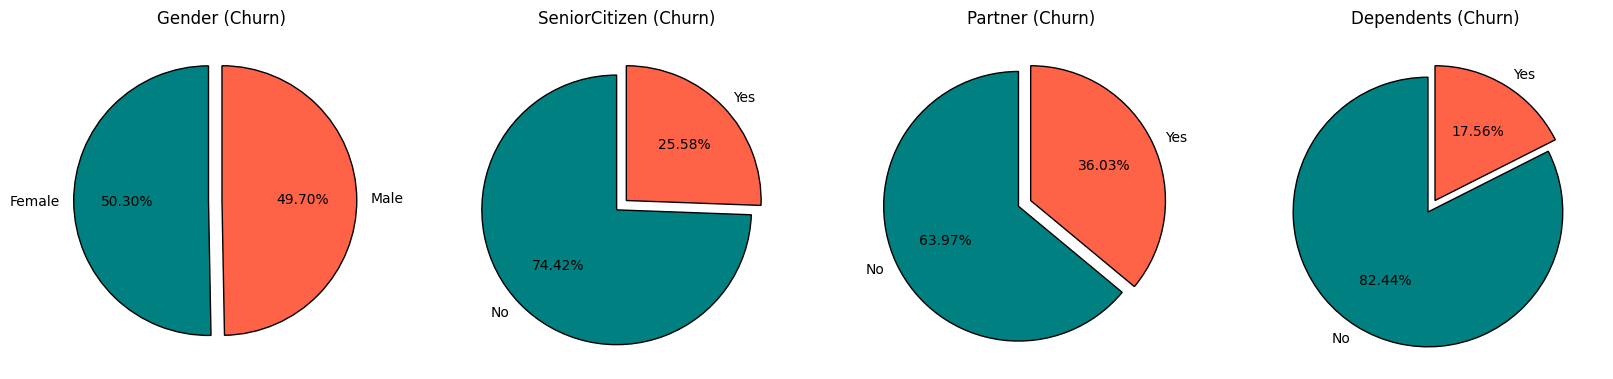

In [28]:
ax,fig = plt.subplots(nrows = 1, ncols = 4, figsize = (20,20))

plt.subplot(1,4,1)
plt.pie(pie_values1,labels = ['Female','Male'],
        autopct='%1.2f%%',
        startangle = 90,
        explode = (0.1,0),
        colors = palette,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Gender (Churn)')

plt.subplot(1,4,2)
plt.pie(pie_values2,labels = ['No','Yes'],
        autopct='%1.2f%%',
        startangle = 90,
        explode = (0.1,0),
        colors = palette,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('SeniorCitizen (Churn)')
plt.subplot(1,4,3)
plt.pie(pie_values3,labels = ['No','Yes'],
        autopct='%1.2f%%',
        startangle = 90,
        explode = (0.1,0),
        colors = palette,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Partner (Churn)')

plt.subplot(1,4,4)
plt.pie(pie_values4,labels = ['No','Yes'],
        autopct='%1.2f%%',
        startangle = 90,
        explode = (0.1,0),
        colors = palette,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Dependents (Churn)')

plt.show()


# Dependence between gender and possibility of churn is small.
# Much more interesting is with Partner, Dependents and SeniorCitizen features.

5.5.2 Provided services

PhoneService, MultipleLines, InternetService, StreamingTV, StreamingMovies

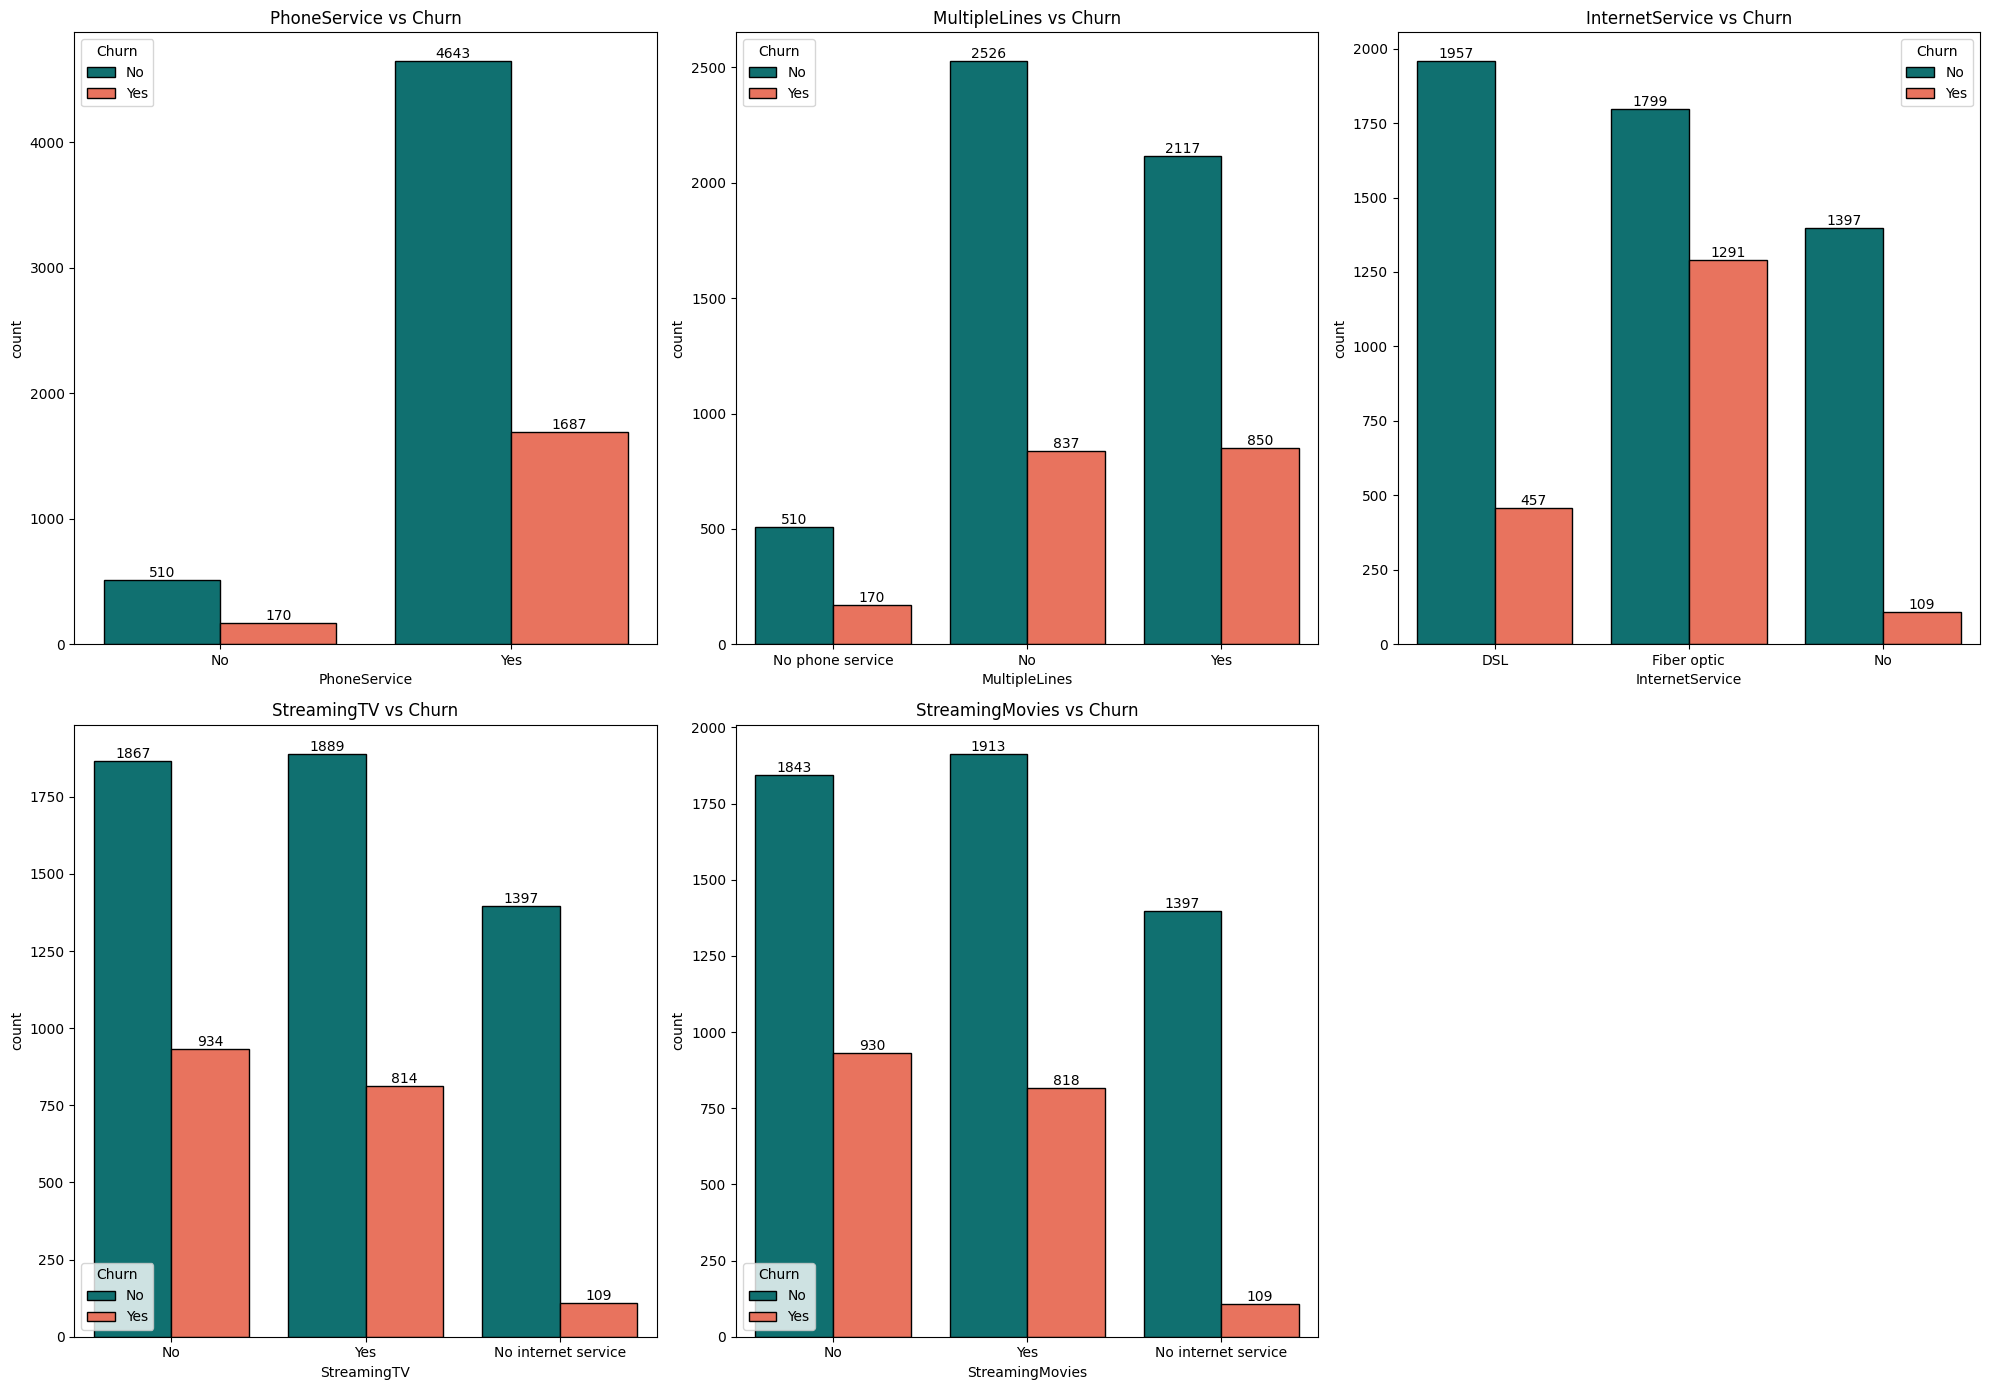

In [29]:
list2 = ['PhoneService', 'MultipleLines', 'InternetService', 'StreamingTV', 'StreamingMovies']
fig = plt.figure(figsize=(20,14))

plt.subplot(2,3,1)
ax = sns.countplot(data = df, x=list2[0], hue = "Churn", palette = palette2, edgecolor = 'black')
ax.legend(loc='upper left', title='Churn')
for i in ax.containers:
    ax.bar_label(i,)
title = list2[0] + ' vs Churn'
plt.title(title);

plt.subplot(2,3,2)
ax = sns.countplot(data = df, x=list2[1], hue = "Churn", palette = palette2, edgecolor = 'black')
ax.legend(loc='upper left', title='Churn')
for i in ax.containers:
    ax.bar_label(i,)
title = list2[1] + ' vs Churn'
plt.title(title);

plt.subplot(2,3,3)
ax = sns.countplot(data = df, x=list2[2], hue = "Churn", palette = palette2, edgecolor = 'black')
ax.legend(loc='upper right', title='Churn')
for i in ax.containers:
    ax.bar_label(i,)
title = list2[2] + ' vs Churn'
plt.title(title)

plt.subplot(2,3,4)
ax = sns.countplot(data = df, x=list2[3], hue = "Churn", palette = palette2, edgecolor = 'black')
ax.legend(loc='lower left', title='Churn')
for i in ax.containers:
    ax.bar_label(i,)
title = list2[3] + ' vs Churn'
plt.title(title);

plt.subplot(2,3,5)
ax = sns.countplot(data = df, x=list2[4], hue = "Churn", palette = palette2, edgecolor = 'black')
ax.legend(loc='lower left', title='Churn')
for i in ax.containers:
    ax.bar_label(i,)
title = list2[4] + ' vs Churn'
plt.title(title);

plt.tight_layout()
plt.show()

In [30]:
phone = df1[df1['Churn'] == 1]['PhoneService'].value_counts()
pie_values1 = [phone[0] / sum(phone) * 100, phone[1] / sum(phone) * 100]

MultipleLines = df1[df1['Churn'] == 1]['MultipleLines'].value_counts()
pie_values2 = [MultipleLines[0] / sum(MultipleLines) * 100, MultipleLines[1] / sum(MultipleLines) * 100, MultipleLines[2] / sum(MultipleLines) * 100]

InternetService = df1[df1['Churn'] == 1]['InternetService'].value_counts()
pie_values3 = [InternetService[0] / sum(InternetService) * 100, InternetService[1] / sum(InternetService) * 100, InternetService[2] / sum(InternetService) * 100]

StreamingTV = df1[df1['Churn'] == 1]['StreamingTV'].value_counts()
pie_values4 = [StreamingTV[0] / sum(StreamingTV) * 100, StreamingTV[1] / sum(StreamingTV) * 100, StreamingTV[2] / sum(StreamingTV) * 100]

StreamingMovies = df1[df1['Churn'] == 1]['StreamingMovies'].value_counts()
pie_values5 = [StreamingMovies[0] / sum(StreamingMovies) * 100, StreamingMovies[1] / sum(StreamingMovies) * 100, StreamingMovies[2] / sum(StreamingMovies) * 100]

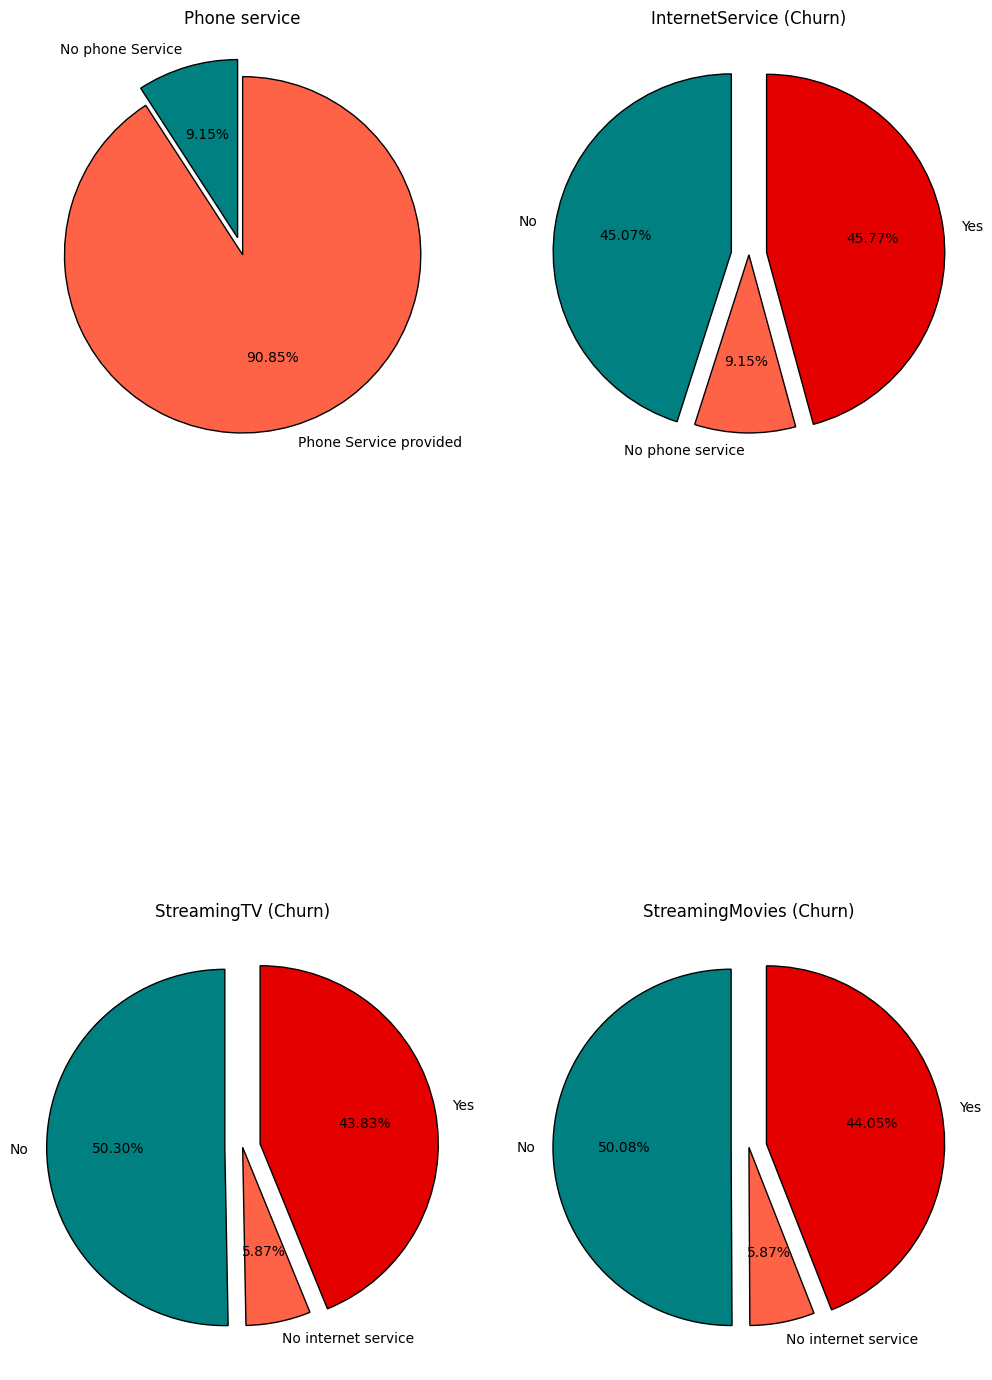

In [31]:
fig = plt.figure(figsize=(15,18))

plt.subplot(2,3,1)
plt.pie(pie_values1,labels = ['No phone Service','Phone Service provided'],
        autopct='%1.2f%%',
        startangle = 90,
        explode = (0.1,0),
        colors = palette,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Phone service')

plt.subplot(2,3,2)
plt.pie(pie_values2,labels = ['No','No phone service','Yes'],
        autopct='%1.2f%%',
        startangle = 90,
        explode = (0.1,0,0.1),
        colors = palette,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('InternetService (Churn)')

plt.subplot(2,3,4)
plt.pie(pie_values4,labels = ['No','No internet service','Yes'],
        autopct='%1.2f%%',
        startangle = 90,
        explode = (0.1,0,0.1),
        colors = palette,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('StreamingTV (Churn)')

plt.subplot(2,3,5)
plt.pie(pie_values5,labels = ['No','No internet service','Yes'],
        autopct='%1.2f%%',
        startangle = 90,
        explode = (0.1,0,0.1),
        colors = palette,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('StreamingMovies (Churn)')

plt.tight_layout()
plt.show()



# A high number of customers who use Fiber for providing the Internet resigned from the service. On the contrary customers who are using DSL don't churn so often.

# Customers without internet have a very low churn rate.


5.5.3 Support services

OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport

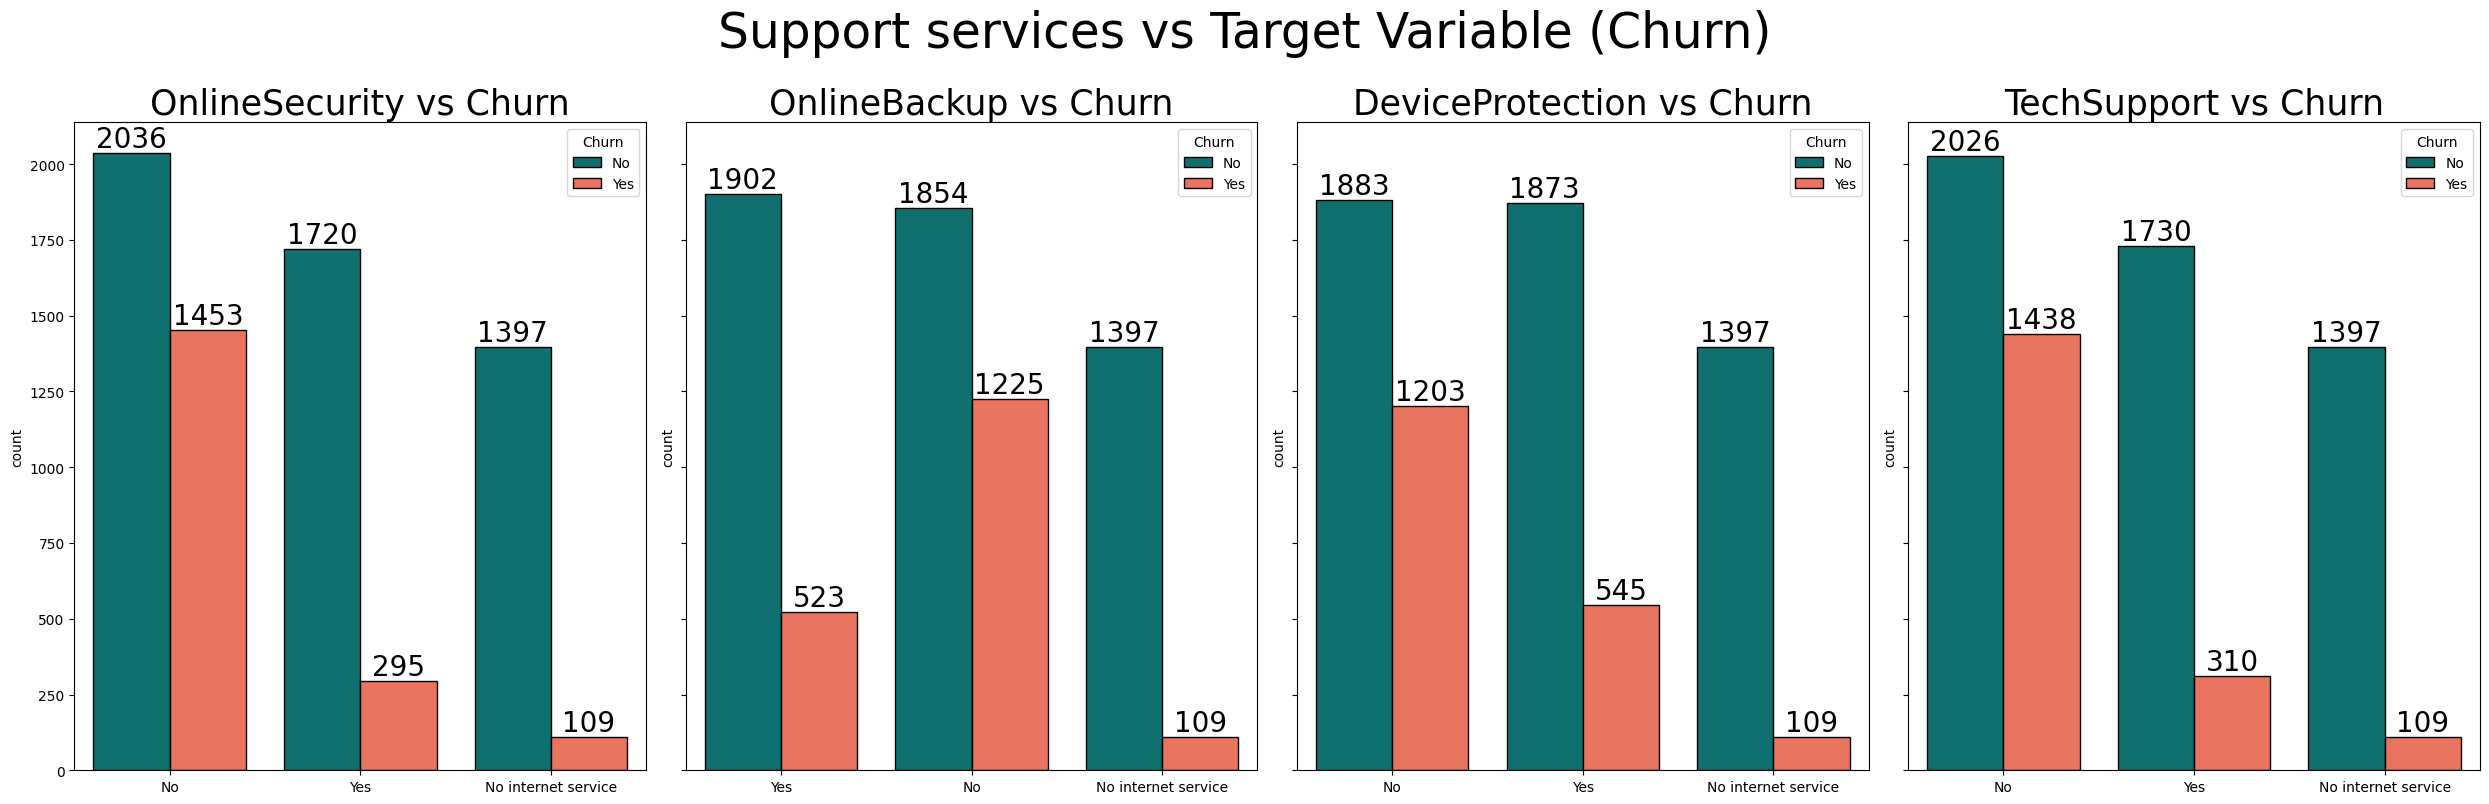

In [32]:
list3 = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']

countplots_custom(dataset=df, columns_list=list3, rows=1, cols=4, figsize=(25,8), hue = hue, palette = palette, suptitle='Support services vs Target Variable (Churn)')
plt.tight_layout()

In [33]:
pie_values1 = df1[df1['Churn'] == 1]['OnlineSecurity'].value_counts()
pie_values1 = [pie_values1[0] / sum(pie_values1) * 100, pie_values1[1] / sum(pie_values1) * 100, pie_values1[2] / sum(pie_values1) * 100]

pie_values2 = df1[df1['Churn'] == 1]['OnlineBackup'].value_counts()
pie_values2 = [pie_values2[0] / sum(pie_values2) * 100, pie_values2[1] / sum(pie_values2) * 100, pie_values2[2] / sum(pie_values2) * 100]

pie_values3 = df1[df1['Churn'] == 1]['DeviceProtection'].value_counts()
pie_values3 = [pie_values3[0] / sum(pie_values3) * 100, pie_values3[1] / sum(pie_values3) * 100, pie_values3[2] / sum(pie_values3) * 100]

pie_values4 = df1[df1['Churn'] == 1]['TechSupport'].value_counts()
pie_values4 = [pie_values4[0] / sum(pie_values4) * 100, pie_values4[1] / sum(pie_values4) * 100, pie_values4[2] / sum(pie_values4) * 100]

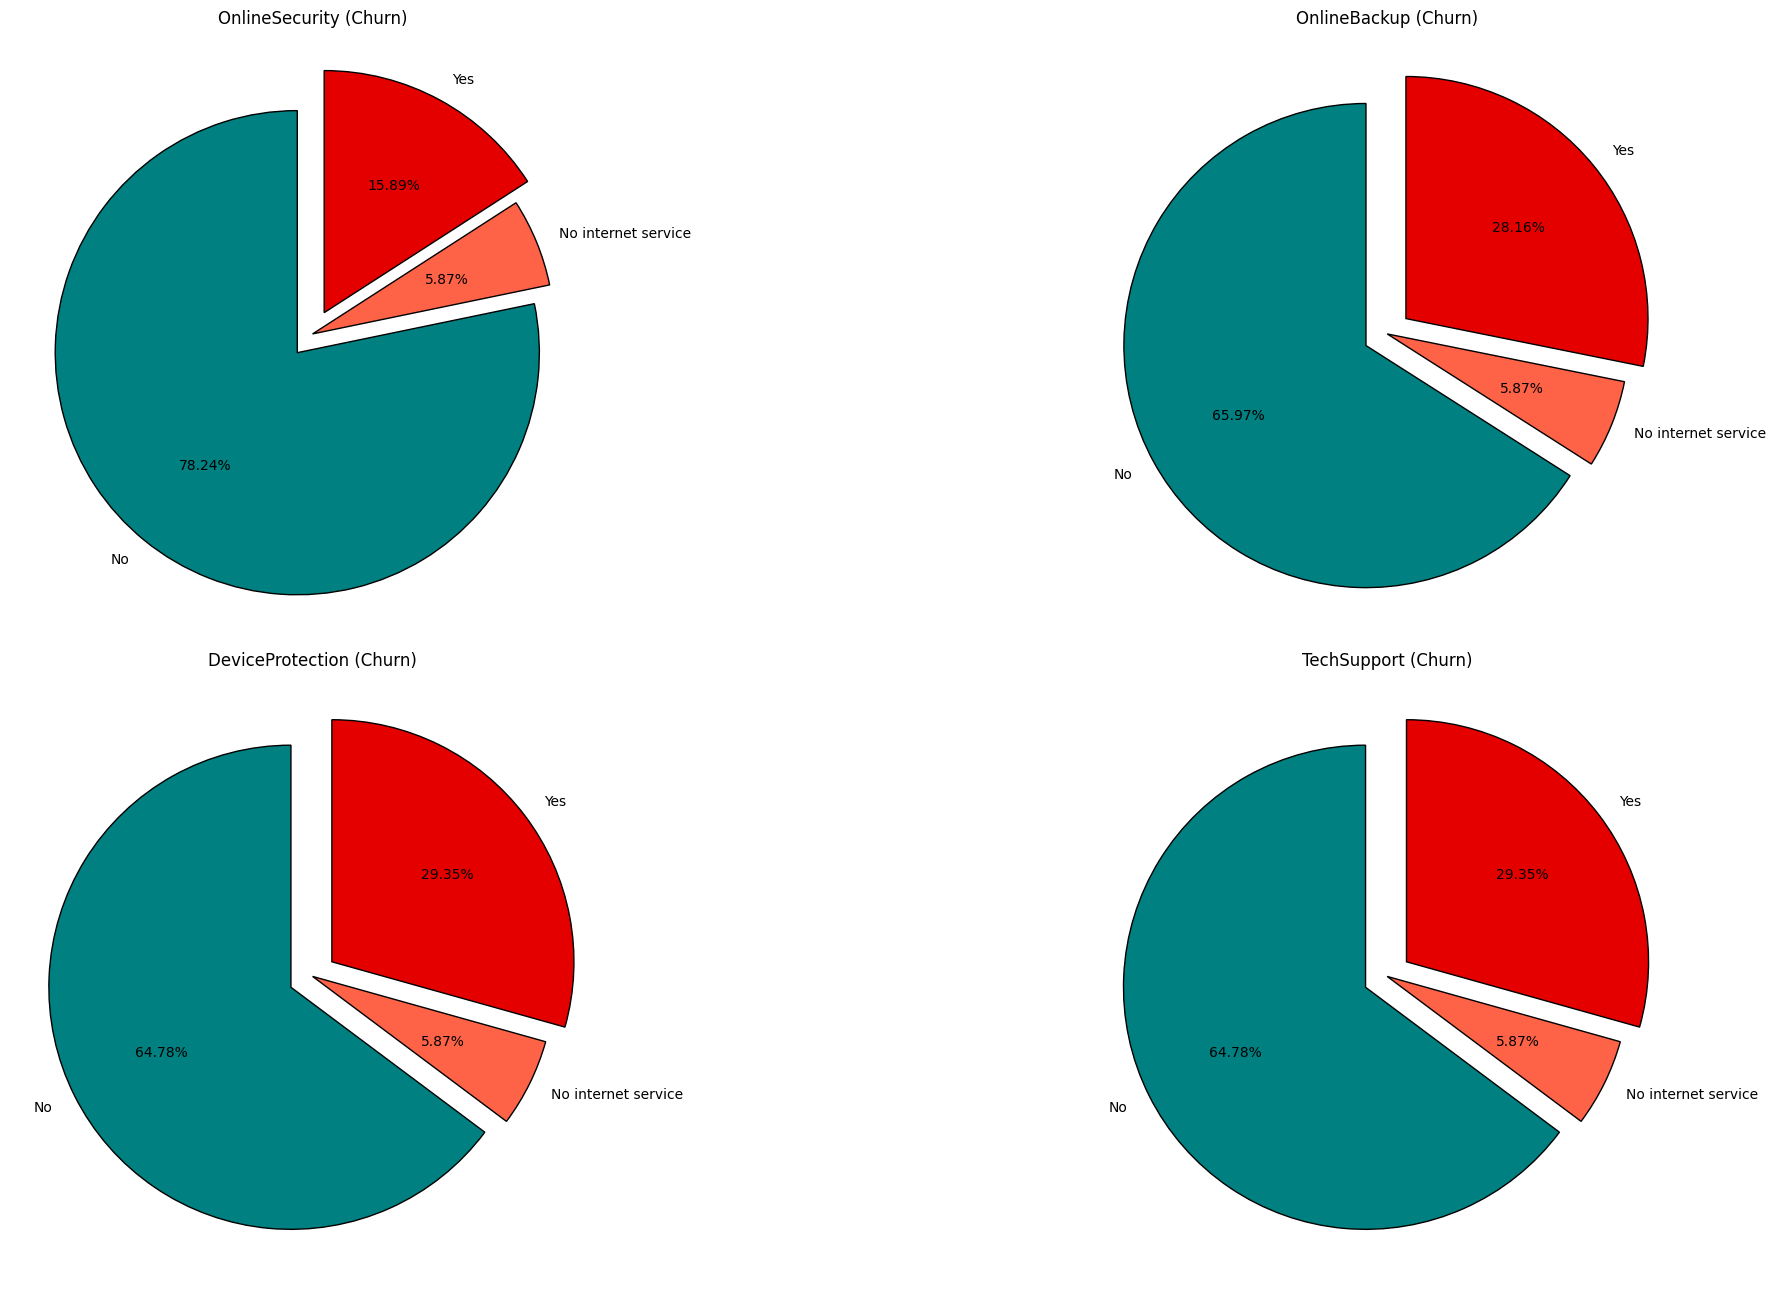

In [34]:
fig = plt.figure(figsize=(25,13))

plt.subplot(2,2,1)
plt.pie(pie_values1,labels = ['No','No internet service','Yes'],
        autopct='%1.2f%%',
        startangle = 90,
        explode = (0.1,0,0.1),
        colors = palette,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('OnlineSecurity (Churn)')

plt.subplot(2,2,2)
plt.pie(pie_values2,labels = ['No','No internet service','Yes'],
        autopct='%1.2f%%',
        startangle = 90,
        explode = (0.1,0,0.1),
        colors = palette,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('OnlineBackup (Churn)')

plt.subplot(2,2,3)
plt.pie(pie_values3,labels = ['No','No internet service','Yes'],
        autopct='%1.2f%%',
        startangle = 90,
        explode = (0.1,0,0.1),
        colors = palette,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('DeviceProtection (Churn)')

plt.subplot(2,2,4)
plt.pie(pie_values3,labels = ['No','No internet service','Yes'],
        autopct='%1.2f%%',
        startangle = 90,
        explode = (0.1,0,0.1),
        colors = palette,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('TechSupport (Churn)')
plt.tight_layout()
plt.show()




# Customers who don't subscribe support services are more likely to churn.

5.5.4 Payments

Contract, PaperlessBilling, PaymentMethod

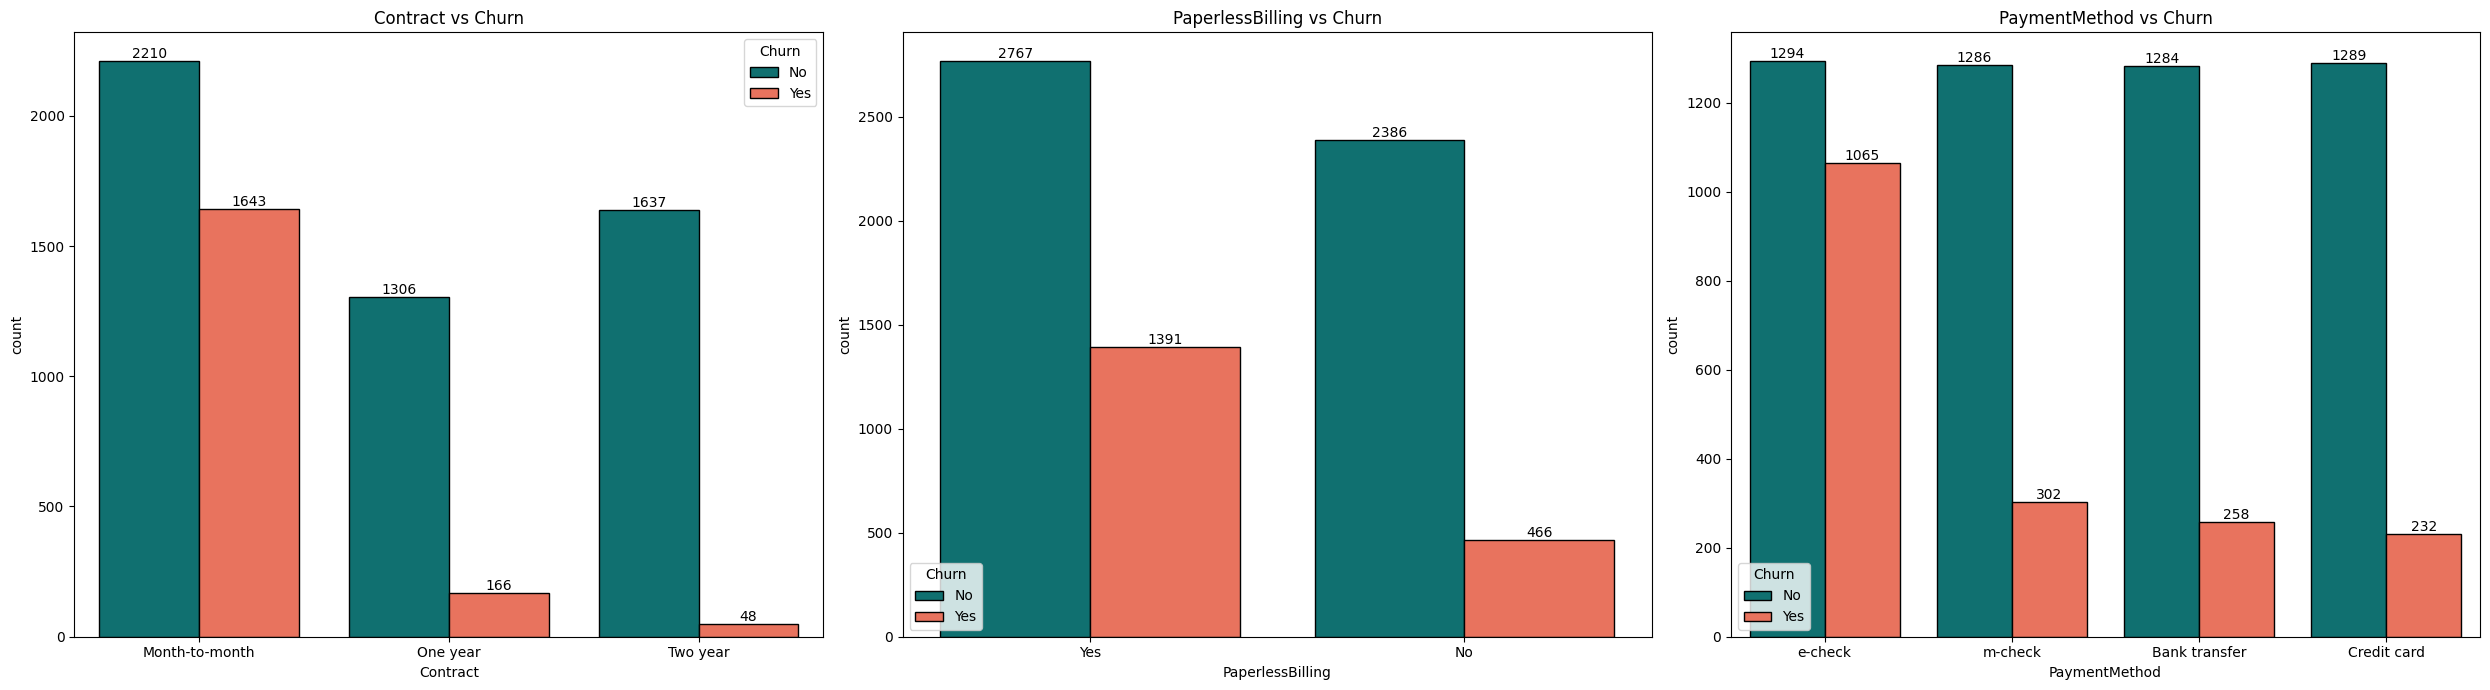

In [35]:
list3 = ['Contract','PaperlessBilling','PaymentMethod']

fig = plt.subplots(nrows = 1, ncols = 3, figsize = (25,7))

plt.subplot(1,3,1)
ax = sns.countplot(data = df, x=list3[0], hue = "Churn", palette = palette2, edgecolor = 'black')
ax.legend(loc='upper right', title='Churn')
for i in ax.containers:
    ax.bar_label(i,)
title = list3[0] + ' vs Churn'
plt.title(title);

plt.subplot(1,3,2)
ax = sns.countplot(data = df, x=list3[1], hue = "Churn", palette = palette2, edgecolor = 'black')
ax.legend(loc='lower left', title='Churn')
for i in ax.containers:
    ax.bar_label(i,)
title = list3[1] + ' vs Churn'
plt.title(title);

plt.subplot(1,3,3)
ax = sns.countplot(data = df, x=list3[2], hue = "Churn", palette = palette2, edgecolor = 'black')
ax.legend(loc='lower left', title='Churn')
for i in ax.containers:
    ax.bar_label(i,)
ax.set_xticklabels(['e-check','m-check','Bank transfer','Credit card'])
title = list3[2] + ' vs Churn'
plt.title(title)

plt.tight_layout()
plt.show()

In [36]:
contract = df1[df1['Churn'] == 1]['Contract'].value_counts()
pie_values1 = [contract[0] / sum(contract) * 100, contract[1] / sum(contract) * 100, contract[2] / sum(contract) * 100]

paperless = df1[df1['Churn'] == 1]['PaperlessBilling'].value_counts()
pie_values2 = [paperless[0] / sum(paperless) * 100, paperless[1] / sum(paperless) * 100]

payment = df1[df1['Churn'] == 1]['PaymentMethod'].value_counts()
pie_values3 = [payment[0] / sum(payment) * 100, payment[1] / sum(payment) * 100, payment[2] / sum(payment) * 100, payment[3] / sum(payment) * 100]

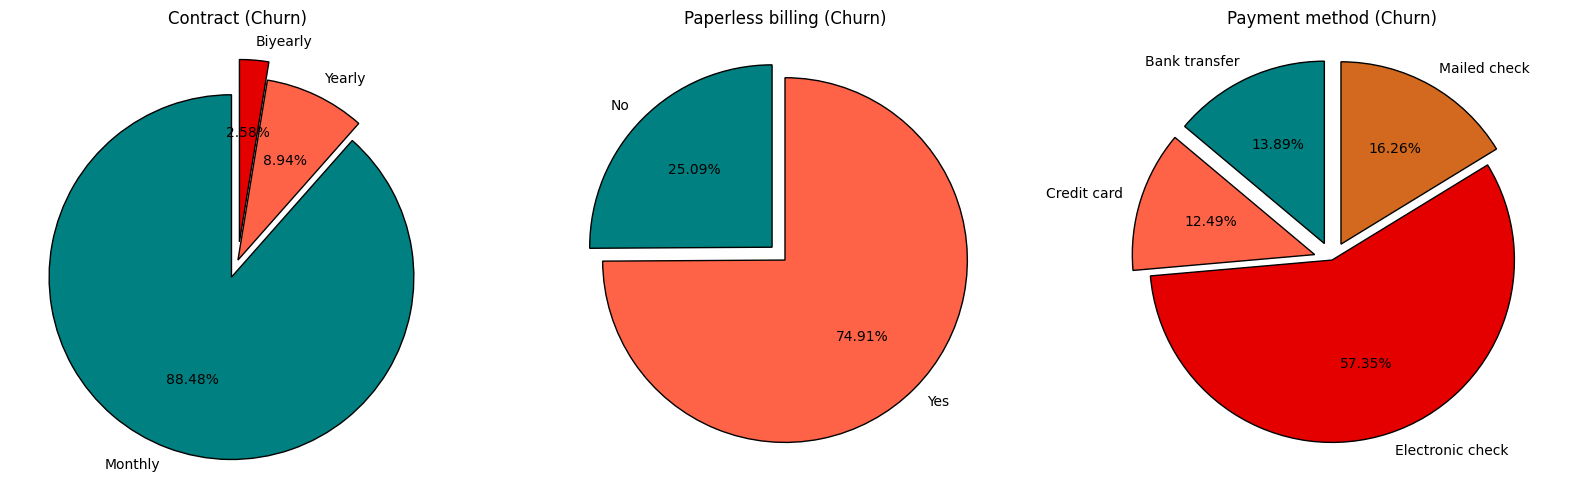

In [37]:
ax,fig = plt.subplots(nrows = 1,ncols = 3,figsize = (20,20))

plt.subplot(1,3,1)
plt.pie(pie_values1,labels = ['Monthly','Yearly','Biyearly'],
        autopct='%1.2f%%',
        startangle = 90,
        explode = (0.1,0,0.1),
        colors = palette,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Contract (Churn)')

plt.subplot(1,3,2)
plt.pie(pie_values2,labels = ['No','Yes'],
        autopct='%1.2f%%',
        startangle = 90,
        explode = (0.1,0),
        colors = palette,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Paperless billing (Churn)')

plt.subplot(1,3,3)
plt.pie(pie_values3,labels = ['Bank transfer','Credit card','Electronic check','Mailed check'],
        autopct='%1.2f%%',
        startangle = 90,
        explode = (0.1,0.1,0,0.1),
        colors = palette,
        wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Payment method (Churn)')

plt.show()


# Short term contracts have much higher churn rates.

# Customers with paperless billing are more probable to churn.

# Customers with electronic check as a payment method are much more likely to churn.

# 6. Feature Engineering

6.1 Train test split - stratified splitting

Stratified splitting means that when you generate a training / validation dataset split, it will attempt to keep the same percentages of classes in each split.

These dataset divisions are usually generated randomly according to a target variable. However, when doing so, the proportions of the target variable among the different splits can differ, especially in the case of small datasets.

In [38]:
df3=df
df3[['Churn']] = df3[['Churn']].apply(le.fit_transform) # Applying LabelEncoder to 'Churn' column

X = df3.drop('Churn', axis=1)
y = df3['Churn']

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.25, random_state = 42)

6.2 Feature scaling

In [40]:
from sklearn.preprocessing import StandardScaler
Standard_Scaler = StandardScaler()
Standard_Scaler.fit_transform(X_train[numeric_columns])
Standard_Scaler.transform(X_test[numeric_columns])

array([[ 0.27610257,  1.01769998,  0.61931885],
       [-1.24037213, -1.53347618, -0.98780549],
       [-1.28135793, -1.33620306, -0.99803605],
       ...,
       [-1.19938633,  0.13498634, -0.90549797],
       [-0.05178385,  0.98259205,  0.30461881],
       [ 0.39905998,  1.17652156,  0.85307838]])

6.3 One hot Encoder

In [41]:
print(categoric_columns)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [42]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
# Encoding multiple columns. Unfortunately you cannot pass a list here so you need to copy-paste all printed categorical columns.
transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'),
     ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
      'PhoneService', 'MultipleLines', 'InternetService',
      'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
      'TechSupport', 'StreamingTV', 'StreamingMovies',
      'Contract', 'PaperlessBilling', 'PaymentMethod']))

In [43]:
# Transforming
transformed = transformer.fit_transform(X_train)
# Transformating back
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
# One-hot encoding removed index. Let's put it back:
transformed_df.index = X_train.index

# Joining tables
X_train = pd.concat([X_train, transformed_df], axis=1)

X_train.drop(categoric_columns, axis=1, inplace=True) # Dropping categorical columns

In [44]:
# Transforming
transformed = transformer.transform(X_test)
# Transformating back
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
# One-hot encoding removed index. Let's put it back:
transformed_df.index = X_test.index

# Joining tables
X_test = pd.concat([X_test, transformed_df], axis=1)

X_test.drop(categoric_columns, axis=1, inplace=True) # Dropping categorical columns

# 7. Model building

In [45]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report

7.1 Feature importance

In [46]:
print(X_train.columns)

Index(['tenure', 'MonthlyCharges', 'TotalCharges',
       'onehotencoder__gender_Female', 'onehotencoder__gender_Male',
       'onehotencoder__SeniorCitizen_0', 'onehotencoder__SeniorCitizen_1',
       'onehotencoder__Partner_No', 'onehotencoder__Partner_Yes',
       'onehotencoder__Dependents_No', 'onehotencoder__Dependents_Yes',
       'onehotencoder__PhoneService_No', 'onehotencoder__PhoneService_Yes',
       'onehotencoder__MultipleLines_No',
       'onehotencoder__MultipleLines_No phone service',
       'onehotencoder__MultipleLines_Yes',
       'onehotencoder__InternetService_DSL',
       'onehotencoder__InternetService_Fiber optic',
       'onehotencoder__InternetService_No', 'onehotencoder__OnlineSecurity_No',
       'onehotencoder__OnlineSecurity_No internet service',
       'onehotencoder__OnlineSecurity_Yes', 'onehotencoder__OnlineBackup_No',
       'onehotencoder__OnlineBackup_No internet service',
       'onehotencoder__OnlineBackup_Yes', 'onehotencoder__DeviceProtection_N

In [47]:
# Setting new feature names

X_train.columns = ['Tenure', 'MonthlyCharges', 'TotalCharges',
       'gender_Female','gender_Male',
       'SeniorCitizen_0','SeniorCitizen_1',
       'Partner_No','Partner_Yes',
       'Dependents_No','Dependents_Yes',
       'PhoneService_No','PhoneService_Yes',
       'MultipleLines_No','MultipleLines_No phone service','MultipleLines_Yes',
       'InternetService_DSL','InternetService_Fiber','InternetService_No',
       'OnlineSecurity_No','OnlineSecurity_NoInternetService','OnlineSecurity_Yes',
       'OnlineBackup_No','OnlineBackup_NoInternetService','OnlineBackup_Yes',
       'DeviceProtection_No','DeviceProtection_NoInternetService','DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_NoInternetService','TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_NoInternetService','StreamingTV_Yes',
       'StreamingMovies_No','StreamingMovies_NoInternetService','StreamingMovies_Yes',
       'Contract_Month-to-month','Contract_One year', 'Contract_Two year',
       'PaperlessBilling_No','PaperlessBilling_Yes',
       'PaymentMethod_BankTransfer','PaymentMethod_CreditCard','PaymentMethod_ElectronicCheck','PaymentMethod_MailedCheck']

X_test.columns = ['Tenure', 'MonthlyCharges', 'TotalCharges',
       'gender_Female','gender_Male',
       'SeniorCitizen_0','SeniorCitizen_1',
       'Partner_No','Partner_Yes',
       'Dependents_No','Dependents_Yes',
       'PhoneService_No','PhoneService_Yes',
       'MultipleLines_No','MultipleLines_No phone service','MultipleLines_Yes',
       'InternetService_DSL','InternetService_Fiber','InternetService_No',
       'OnlineSecurity_No','OnlineSecurity_NoInternetService','OnlineSecurity_Yes',
       'OnlineBackup_No','OnlineBackup_NoInternetService','OnlineBackup_Yes',
       'DeviceProtection_No','DeviceProtection_NoInternetService','DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_NoInternetService','TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_NoInternetService','StreamingTV_Yes',
       'StreamingMovies_No','StreamingMovies_NoInternetService','StreamingMovies_Yes',
       'Contract_Month-to-month','Contract_One year', 'Contract_Two year',
       'PaperlessBilling_No','PaperlessBilling_Yes',
       'PaymentMethod_BankTransfer','PaymentMethod_CreditCard','PaymentMethod_ElectronicCheck','PaymentMethod_MailedCheck']
# After renaming the columns

X_train.head()

,Tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_BankTransfer,PaymentMethod_CreditCard,PaymentMethod_ElectronicCheck,PaymentMethod_MailedCheck
1956,42,60.15,2421.60,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3135,14,76.45,1117.55,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5058,44,54.30,2390.45,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
4647,32,74.75,2282.95,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
118,41,20.65,835.15,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [48]:
# Running logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
from sklearn import metrics
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print (metrics.accuracy_score(y_test, prediction_test))

0.8054763262977752


In [50]:
from sklearn.svm import SVC

model.svm = SVC(kernel='linear')
model.svm.fit(X_train,y_train)
preds = model.svm.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.7912150598973189

In [51]:
# Create the Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,preds))

[[1195   94]
 [ 272  192]]


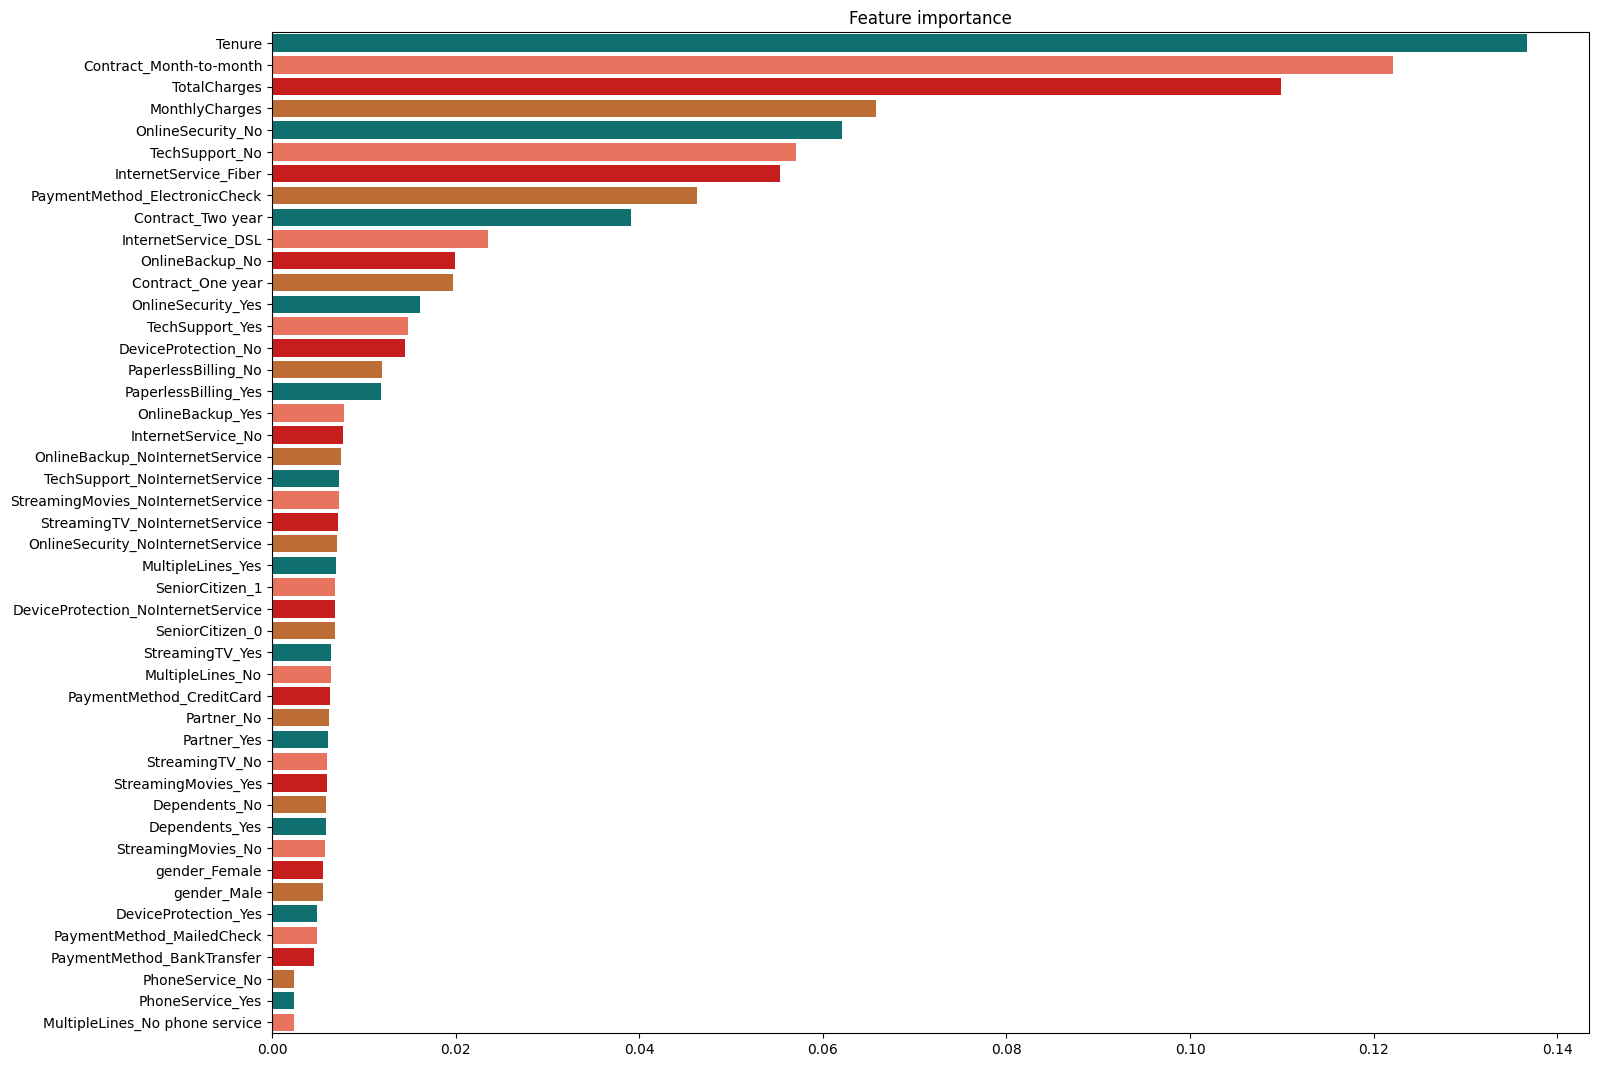

In [52]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=3, n_estimators=5000, random_state=13)
clf = clf.fit(X_train, y_train)

fimp = pd.Series(data=clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(17,13))
plt.title("Feature importance")
ax = sns.barplot(y=fimp.index, x=fimp.values, palette=palette, orient='h')

7.2 Baseline - Random Forest

In [53]:
rf = RandomForestClassifier(random_state=13)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [54]:
rf_Recall = recall_score(y_test, y_pred)
rf_Precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)
rf_roc_auc = roc_auc_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1168  121]
 [ 241  223]]


In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1289
           1       0.65      0.48      0.55       464

    accuracy                           0.79      1753
   macro avg       0.74      0.69      0.71      1753
weighted avg       0.78      0.79      0.78      1753



7.2.1 K-Fold Cross-validation

In [56]:
from statistics import stdev
score = cross_val_score(rf, X_train, y_train, cv=5, scoring='recall', error_score="raise")
rf_cv_score = score.mean()
rf_cv_stdev = stdev(score)
print('Cross Validation Recall scores are: {}'.format(score))
print('Average Cross Validation Recall score: ', rf_cv_score)
print('Cross Validation Recall standard deviation: ', rf_cv_stdev)

Cross Validation Recall scores are: [0.44444444 0.47311828 0.49640288 0.48920863 0.52329749]
Average Cross Validation Recall score:  0.4852943451690261
Cross Validation Recall standard deviation:  0.029154464510727836


In [57]:
ndf = [(rf_Recall, rf_Precision, rf_f1, rf_accuracy, rf_roc_auc, rf_cv_score, rf_cv_stdev)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy', 'ROC-AUC Score', 'Avg CV Recall', 'Standard Deviation of CV Recall'])
rf_score.insert(0, 'Model', 'Random Forest')
rf_score

,Model,Recall,Precision,F1 Score,Accuracy,ROC-AUC Score,Avg CV Recall,Standard Deviation of CV Recall
0,Random Forest,0.480603,0.648256,0.55198,0.793497,0.693366,0.485294,0.029154


Recall score: 0,48 means that in this particular situation we were able to detect 48% of churning customers. We probably expected more so we need to tune our model. Recall is a very important score in our case.

Avg CV Recall: 0.48 (the same) means that in an average situation we can expect Recall score at about 0,5 (the higher the better). Our model is probably reliable in terms of bringing recurrent results (the same score). That’s a good news.

Standard Deviation of CV Recall: 0.03 tell us about expected differences with Recall Score (the lower the better). 0.026 is a good result.

ROC-AUC Score: 0.70 tells us that the model is quite efficient at distinguishing between the churn customers and not churn customers.

Accuracy: 0.79 tells us that the number of correct predictions (churn and not churn) made by a model in relation to the total number of predictions are 79%. Accuracy is not a good score for imbalanced data set.

Precision: 0.65 tells us that when our model predicts a churn customer we have a 67% chance that the prediction is accurate (we detected a churn customer).

F1 Score: 0.55 tells us how efficient our model is, taking into account both: Recall and Precision scores.


7.2.2 Hyperparameter Tuning Using GridSearchCV

In [58]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [130], # 'n_estimators': [120,130,150,170,190,200],
    'max_depth': [14],  # 'max_depth': [8,10,12,14,15],
    'min_samples_split': [3], # 'min_samples_split': [3,4,5,6],
    'min_samples_leaf': [2], # 'min_samples_leaf': [1,2,3],
    'random_state': [13]
}

grid_rf = GridSearchCV(rf, param_grid=params, cv=5, scoring='recall').fit(X_train, y_train)

In [59]:
print('Best parameters:', grid_rf.best_params_)
print('Best score:', grid_rf.best_score_)

Best parameters: {'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 130, 'random_state': 13}
Best score: 0.5046775482839535


In [60]:
y_pred = grid_rf.predict(X_test)

In [61]:
cm = confusion_matrix(y_test, y_pred)

grid_rf_Recall = recall_score(y_test, y_pred)
grid_rf_Precision = precision_score(y_test, y_pred)
grid_rf_f1 = f1_score(y_test, y_pred)
grid_rf_accuracy = accuracy_score(y_test, y_pred)
grid_roc_auc = roc_auc_score(y_test, y_pred)

print(cm)

[[1161  128]
 [ 238  226]]


7.2.3 K-Fold Cross-validation

In [62]:
score2 = cross_val_score(grid_rf, X_train, y_train, cv=5, scoring='recall')

In [63]:
grid_cv_score = score2.mean()
grid_cv_stdev = stdev(score2)

print('Cross Validation Recall scores are: {}'.format(score2))
print('Average Cross Validation Recall score: ', grid_cv_score)
print('Cross Validation Recall standard deviation: ', grid_cv_stdev)

Cross Validation Recall scores are: [0.47670251 0.48028674 0.50359712 0.52158273 0.54121864]
Average Cross Validation Recall score:  0.5046775482839535
Cross Validation Recall standard deviation:  0.027384842018450185


In [64]:
ndf2 = [(grid_rf_Recall, grid_rf_Precision, grid_rf_f1, grid_rf_accuracy, grid_roc_auc, grid_cv_score, grid_cv_stdev)]

grid_score = pd.DataFrame(data = ndf2, columns=
                        ['Recall','Precision','F1 Score', 'Accuracy', 'ROC-AUC Score', 'Avg CV Recall', 'Standard Deviation of CV Recall'])
grid_score.insert(0, 'Model', 'Random Forest after tuning')
grid_score

,Model,Recall,Precision,F1 Score,Accuracy,ROC-AUC Score,Avg CV Recall,Standard Deviation of CV Recall
0,Random Forest after tuning,0.487069,0.638418,0.552567,0.791215,0.693884,0.504678,0.027385


Interpretation results after tuning hyperparameters:

Recall score is better: 0,49 (was: 0,48) - that means that we were able to detect 49% of churning customers.

Avg CV Recall is better: 0.50 (was: 0.48) - that means that we can expect better average results when it comes to Recall score. This is probably the most important improvement.

Standard Deviation of CV Recall is almost the same: 0.027 (was: 0.03).

ROC-AUC Score is: 0.69 - the model is quite efficient at distinguishing between the churn customers and not churn customers.

Accuracy: 0.79 (the same) - no progress here, but that is not very important.

Precision: 0,64 (the same) - when our model predicts a churn customer we have a 64% chance that the prediction is accurate (we really detect a churn customer).

F1 Score: 0.55 - the result is the same.